In [1]:
#Please keep mind that the report is wrote from the we pronoun but I'm the only author, I'm used to write from an essay perspective

# Problem analysis and data extracting

We have been given the problem of gender voice recognition (binary classification) where the dataset needs to be extracted and processed by ourselves (just like real life, not kaggle datasets). In this notebook we will present an exploratory data analysis for the dataset and some proposed models along with some comments on how and why things are done.

Before we perform the EDA we will first explain how the dataset was extracted. The data extracting and dataset process consists of 3 files attached along with this notebook:

**Scraper.py**: Python script to find and download all the tgz files from the provided URL for the problem.

**dataset.py**: PythonScript where we open tgz files to explore wavs files along extra files to extract features such as age, dialect, fileType, channels and more metadata. This file creates a CSV file containing the path for each wav file along the features extracted.

**scriptR.R**: A parallelized R script where the warbleR library for audio processing is used, the script reads the previous csv and appends the features obtained from the [&lt;Specan function&gt;](https://www.rdocumentation.org/packages/warbleR/versions/1.1.14/topics/specan) to create the dataset we will be using in this notebook.

The resulting audio_dataset.csv is included in the git repository so it is not necessary to run to run the scripts again (bear in mind it takes around 5 hours to fully download and process everything in R).

The 3 files have been coded to run locally on my machine with my specific paths, in case the project required automatization for the data extraction part we would add arg.parsers so they are able to scale and, additionally, we would add correct coding policies such as exception handling. 


# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

<a name=Indice></a>
# Table of Contents
1. [Exploratory data analysis](#EDA)
 * [Brief overview of the dataset](#Loadthedatasetandgetabriefoverview)
 * [Target variable analysis](#Targetvariableanalysis)
 * [Independent variables analysis](#Independentvariablesanalysis)
  + [Continuous features](#Continuousfeatures)
  + [Categorical features](#Categoricalfeatures)
2. [Preprocessing](#Preprocessing)
  * [Preparing data](#Preparethedata)
  * [Balancing data](#Balancingdata)
  * [Expand dataset with external sources](#Expanding)
  * [Feature selection](#Featureselection)
3. [Building the model](#Buildingthemodel)
    * [Metric](#Choosingthemetricforourmodels)
    * [SVM](#SVM)
    * [XGBoost](#XGBoost)
    * [Tuning model parameters](#Tuningthemodelparameters)
     + [SVM](#SVMtuning)
     + [XGBoost](#XGBoosttuning)
    * [DNN](#DNN)
4. [Conclusion and future work](#Conclusionandfuturework)

In [4]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.metrics import accuracy_score, roc_auc_score,log_loss, matthews_corrcoef
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.cross_validation import cross_val_score, StratifiedKFold, StratifiedShuffleSplit
from sklearn.utils import resample
from scipy import stats
%matplotlib inline

import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn import cross_validation, metrics  
from sklearn.grid_search import GridSearchCV  

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
import tensorflow.keras as keras
from sklearn.model_selection import StratifiedKFold
from bayes_opt import BayesianOptimization
import contextlib
import gc
import contextlib

target='gender'
tf.set_random_seed(17)
np.random.seed(17)



The objective of this notebook is to explore and process the already extracted dataset and present a series of models to predict a user's gender from .wav samples. The best model for the problem can't be defined yet as we are not yet familiar with this use case or scenario it would take place in.




# EDA


<a name=Loadthedatasetandgetabriefoverview></a>
## Load the dataset and get a brief overview
[Return to table of contents](#Indice)

In [12]:
dataframe=pd.read_csv("audios_dataset.csv")
dataframeOriginal =pd.read_csv("audios_dataset.csv") #backup in case we need to access original df after transforming it
print('\nDataframe shape: {}'.format(dataframe.shape))


Dataframe shape: (86647, 41)


Lets see the features our dataset is composed of

In [13]:
dataframe.head(5)

,Unnamed: 0,sound.files,user,age,gender,language,dialect,fileType,rate,rateFormat,...,maxfun,meandom,mindom,maxdom,dfrange,modindx,startdom,enddom,dfslope,meanpeakf
0,1,audio1.wav,topherfangio,Adult,male,EN,AmericanEnglishn,wav,48000,16,...,5.333333,0.319481,0.03125,3.46875,3.43750,6.109091,0.56250,0.06250,0.0,0.110491
1,2,audio10.wav,topherfangio,Adult,male,EN,AmericanEnglishn,wav,48000,16,...,5.333333,0.889381,0.03125,6.78125,6.75000,5.509259,0.21875,1.65625,0.0,0.078869
2,3,audio100.wav,Peter,Adult,male,EN,CanadianEnglishn,wav,48000,16,...,5.333333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.047247
3,4,audio1000.wav,anonymous,adult,male,EN,AmericanEnglishn,wav,48000,16,...,5.333333,0.334746,0.03125,0.56250,0.53125,8.882353,0.37500,0.40625,0.0,0.047247
4,5,audio10000.wav,LAVEENAZ,Adult,male,EN,AmericanEnglishn,wav,48000,16,...,5.333333,0.868608,0.03125,4.81250,4.78125,6.921569,0.62500,0.03125,0.0,0.047247


In [14]:
#All the feature types
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 86647 entries, 0 to 86646
Data columns (total 41 columns):
Unnamed: 0     86647 non-null int64
sound.files    86647 non-null object
user           86647 non-null object
age            86647 non-null object
gender         85093 non-null object
language       82088 non-null object
dialect        86647 non-null object
fileType       86067 non-null object
rate           86647 non-null int64
rateFormat     85762 non-null object
channels       85623 non-null float64
selec          86647 non-null int64
duration       86647 non-null float64
meanfreq       86647 non-null float64
sd             86647 non-null float64
freq.median    86647 non-null float64
freq.Q25       86647 non-null float64
freq.Q75       86647 non-null float64
freq.IQR       86647 non-null float64
time.median    86647 non-null float64
time.Q25       86647 non-null float64
time.Q75       86647 non-null float64
time.IQR       86647 non-null float64
skew           86647 non-null f

We observe that we have a majority of continuous features (good for our models) and some of the features have different non-null numbers of rows, meaning some of them will have nulls or Nan (we will deal with them later).

Now we will get rid of the columns that won't give us any extra information such as index/ audio.name /user (a user has one unique gender) that have any sense be in the final model.


In [15]:
#drop the trash column, probably the index
dataframe.drop('duration',inplace=True,axis=1)
dataframe.drop('sound.files',inplace=True,axis=1)
dataframe.drop('Unnamed: 0',inplace=True,axis=1)
dataframe.drop('user',inplace=True,axis=1)
dataframe.drop('rate',inplace=True,axis=1)

In [16]:
continuousFeatures = dataframe.select_dtypes(include=['float64','int64']).columns
categoricalFeatures = dataframe.select_dtypes(include='object').columns

Let's see a sample of our categorical featues

In [17]:
dataframe[categoricalFeatures].head(10)

,age,gender,language,dialect,fileType,rateFormat
0,Adult,male,EN,AmericanEnglishn,wav,16
1,Adult,male,EN,AmericanEnglishn,wav,16
2,Adult,male,EN,CanadianEnglishn,wav,16
3,adult,male,EN,AmericanEnglishn,wav,16
4,Adult,male,EN,AmericanEnglishn,wav,16
5,Adult,male,EN,AmericanEnglishn,wav,16
6,Adult,male,EN,AmericanEnglishn,wav,16
7,Adult,male,EN,AmericanEnglishn,wav,16
8,Adult,male,EN,AmericanEnglishn,wav,16
9,Adult,male,EN,AmericanEnglishn,wav,16


rateFormat may not be a categorical feature but all others seem correct. We will deal with rateFormat in preprocessing

A sample of our dataset at the moment

In [18]:
dataframe.head()

,age,gender,language,dialect,fileType,rateFormat,channels,selec,meanfreq,sd,...,maxfun,meandom,mindom,maxdom,dfrange,modindx,startdom,enddom,dfslope,meanpeakf
0,Adult,male,EN,AmericanEnglishn,wav,16,1.0,1,1.624672,1.751428,...,5.333333,0.319481,0.03125,3.46875,3.43750,6.109091,0.56250,0.06250,0.0,0.110491
1,Adult,male,EN,AmericanEnglishn,wav,16,1.0,1,1.879392,1.847794,...,5.333333,0.889381,0.03125,6.78125,6.75000,5.509259,0.21875,1.65625,0.0,0.078869
2,Adult,male,EN,CanadianEnglishn,wav,16,1.0,1,2.766250,1.862706,...,5.333333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.047247
3,adult,male,EN,AmericanEnglishn,wav,16,1.0,1,0.981539,1.490405,...,5.333333,0.334746,0.03125,0.56250,0.53125,8.882353,0.37500,0.40625,0.0,0.047247
4,Adult,male,EN,AmericanEnglishn,wav,16,1.0,1,2.298092,1.945568,...,5.333333,0.868608,0.03125,4.81250,4.78125,6.921569,0.62500,0.03125,0.0,0.047247


<a name=Targetvariableanalysis></a>

## Target variable analysis
[Return to table of contents](#Indice)

We now want to study our target variable, let's see how many classes it has(should be two, but there might be have errors in the data caused by typos), how they are distributed aswell as also getting rid of nulls/nans.

In [19]:
dataframe.gender.unique()

array(['male', 'female', nan], dtype=object)

In [20]:
#There are some samples with nan in the gender, we cant use them
dataframe.dropna(subset=['gender'],inplace=True)


In [21]:
dataframe.gender.describe()

count     85093
unique        2
top        male
freq      72161
Name: gender, dtype: object

In [22]:
print("Total number of labels: {}".format(dataframe.shape[0]))
print("Number of male: {}".format(dataframe[dataframe.gender == 'male'].shape[0]))
print("Number of female: {}".format(dataframe[dataframe.gender == 'female'].shape[0]))
print("Target variable balance: {0}{1}".format( (dataframe[dataframe.gender == 'male'].shape[0]) / (dataframe.shape[0]),"% males"))

Total number of labels: 85093
Number of male: 72161
Number of female: 12932
Target variable balance: 0.8480251019472812% males


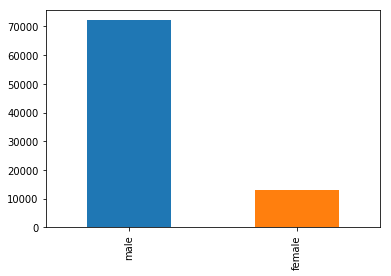

In [23]:
dataframe['gender'].value_counts().plot(kind='bar')
plt.show()

We see that our target variable is terribly balanced (as usual in the real world) we will deal with that in later sections.

In [24]:
#we are also going to encode the target variable female=1 male=0 to make things easier for our models
dataframe['gender'] = dataframe['gender'].map({'female': 1, 'male': 0})

In [25]:
dataframe.head()

,age,gender,language,dialect,fileType,rateFormat,channels,selec,meanfreq,sd,...,maxfun,meandom,mindom,maxdom,dfrange,modindx,startdom,enddom,dfslope,meanpeakf
0,Adult,0,EN,AmericanEnglishn,wav,16,1.0,1,1.624672,1.751428,...,5.333333,0.319481,0.03125,3.46875,3.43750,6.109091,0.56250,0.06250,0.0,0.110491
1,Adult,0,EN,AmericanEnglishn,wav,16,1.0,1,1.879392,1.847794,...,5.333333,0.889381,0.03125,6.78125,6.75000,5.509259,0.21875,1.65625,0.0,0.078869
2,Adult,0,EN,CanadianEnglishn,wav,16,1.0,1,2.766250,1.862706,...,5.333333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.047247
3,adult,0,EN,AmericanEnglishn,wav,16,1.0,1,0.981539,1.490405,...,5.333333,0.334746,0.03125,0.56250,0.53125,8.882353,0.37500,0.40625,0.0,0.047247
4,Adult,0,EN,AmericanEnglishn,wav,16,1.0,1,2.298092,1.945568,...,5.333333,0.868608,0.03125,4.81250,4.78125,6.921569,0.62500,0.03125,0.0,0.047247


<a name=Independentvariablesanalysis></a>


## Independent variables analysis
[Return to table of contents](#Indice)

We now present a study of both continuous and categorical features, studying its distributions against target variable gender and the correlations between them.

<a name=Continuousfeatures></a>

### Continuous features
[Return to table of contents](#Indice)

In [26]:
#For the rest of the expriment we will transform nans in continouos features with 0
dataframe[continuousFeatures] = dataframe[continuousFeatures].fillna(value=0)

We want to know how our features distribute when comparing them to the gender target,  to do so we will evaluate the distributions for every single feature when having gender male against female. The objective is  to find features with different distributions for each gender, this features will be of extremely importance in the later models.


/Users/jiwidi/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/Users/jiwidi/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


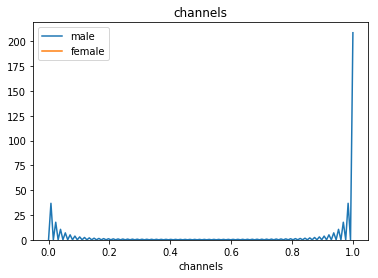

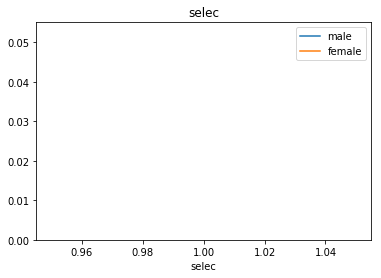

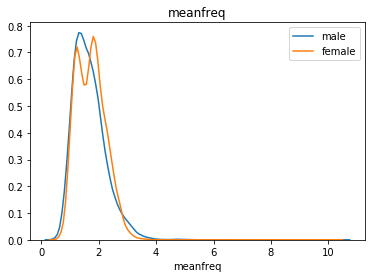

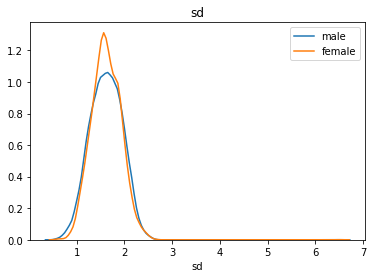

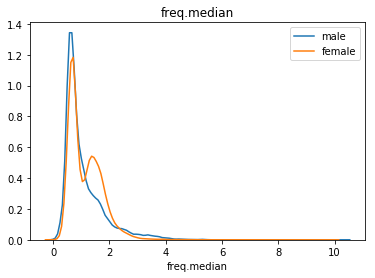

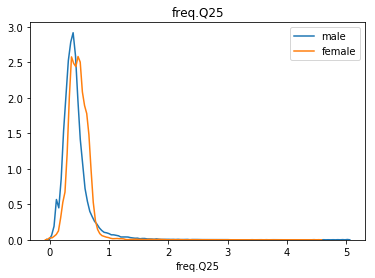

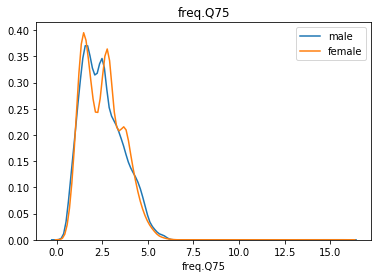

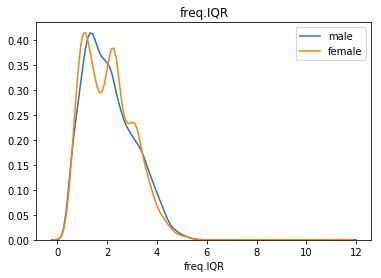

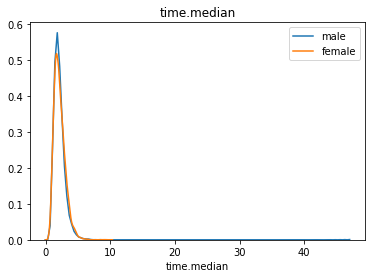

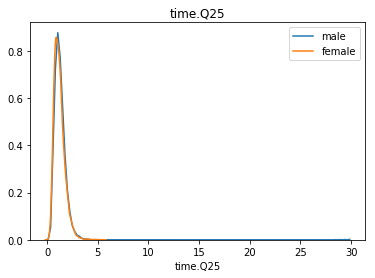

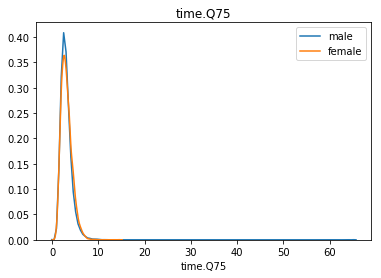

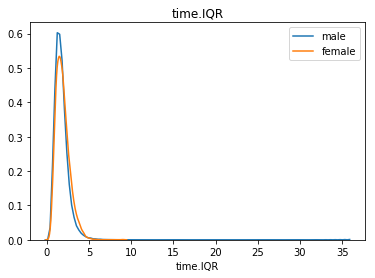

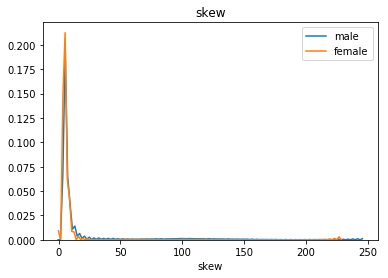

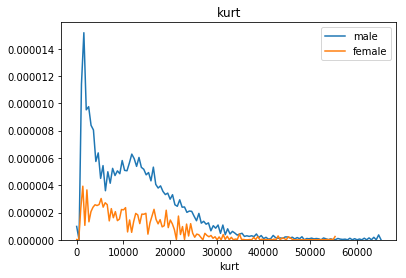

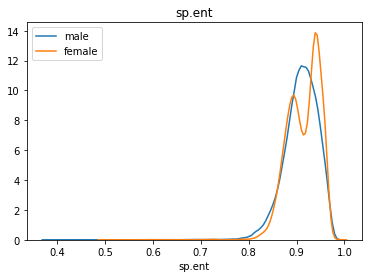

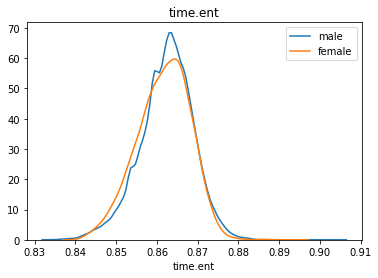

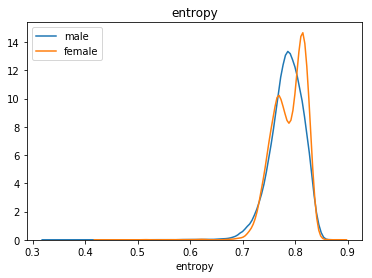

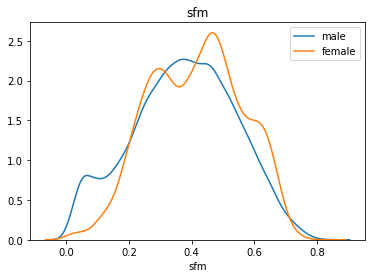

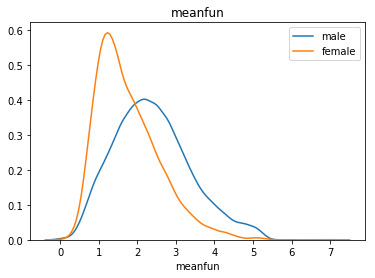

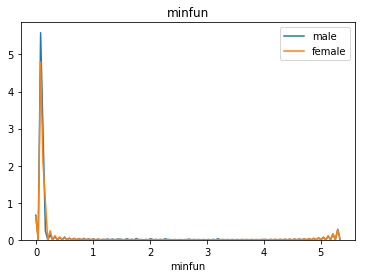

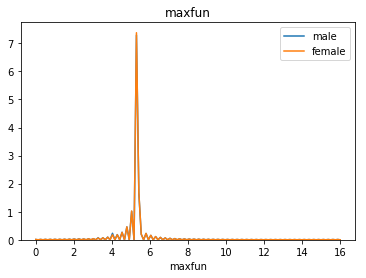

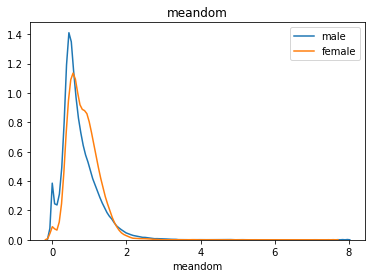

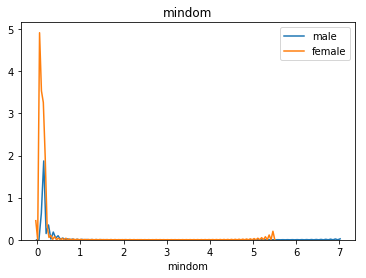

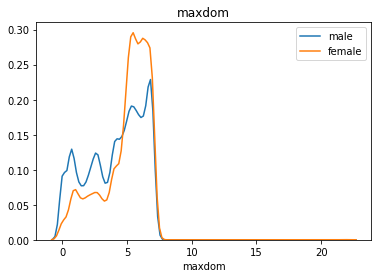

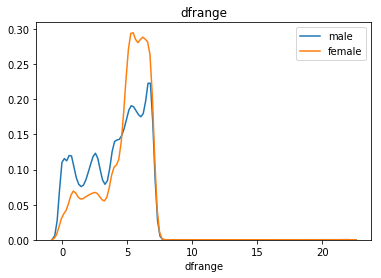

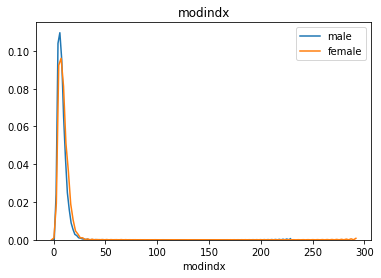

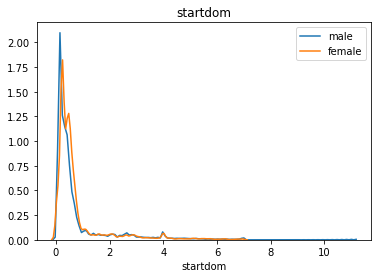

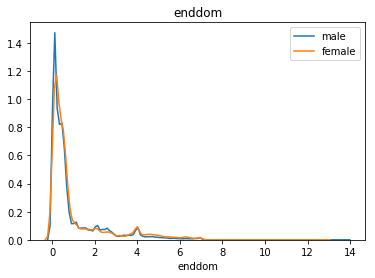

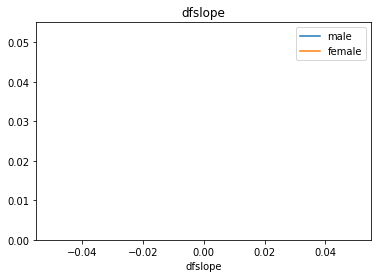

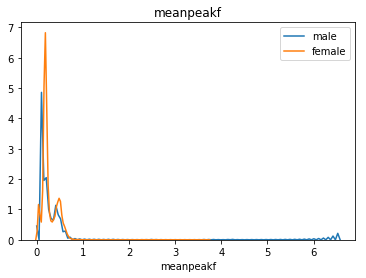

In [27]:
#Plot features distributions distinguing by the target variable gender
for idx,column in enumerate(continuousFeatures):
    try:
        target_0 = dataframe.loc[dataframe['gender'] == 0]
        target_1 = dataframe.loc[dataframe['gender'] == 1]

        sns.distplot(target_0[column], hist=False,label='male')
        sns.distplot(target_1[column], hist=False,label='female').set_title(column)
        plt.legend()
        plt.show()
    except:
        pass


With the feature distribution of male against female we gain insight as to what features could be important for our model. We can classify them in 3 groups depending on how much the distributions differed.

**Notable difference**:
kurt,meanfun,mindom,maxdom,,dfrange. 

**Sligh differences**:
sd,frq.median,sp.ent,time.ent,entropy,sfm,meandom,meanpeakf 

**Almost no difference**:
select,channels,.modindx,startdom,enddom,dfslope,minfun,maxfun,meanfreq,freq.q25,freq.q75,feq.IQR,time.median,time.q25,time.q75,time.IQR,skew

We will keep this groups in mind for our feature extraction in the next sections


Another way of studying our features is to see the correlation matrix of the dataset, we can see how features correlate with gender (meaning they will be good for our models) but also correlations between features to check if we have duplicate "information" in 2 features.

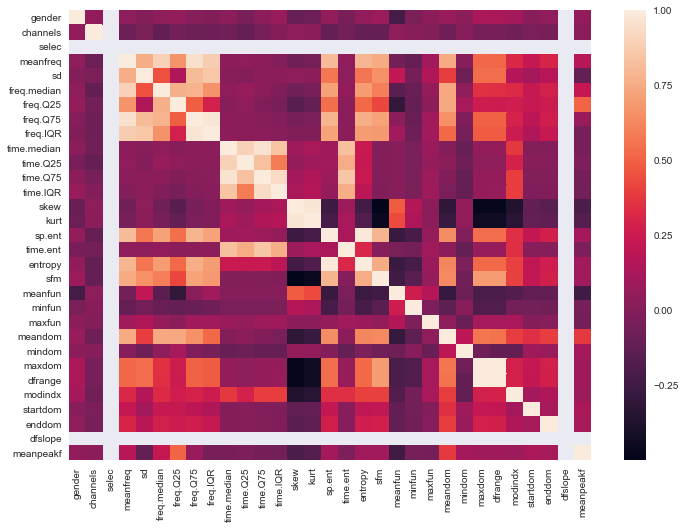

In [28]:
#Correlation map
corrmat = dataframe.corr()


sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.heatmap(corrmat)

First we see the big correlated features dfslope and slope, thats due to them having constant values so we will ignore them (they will be removed in preprocessing). In other features we are not able to see high correlations with the color scheme, let's print the values to get a better perspective.


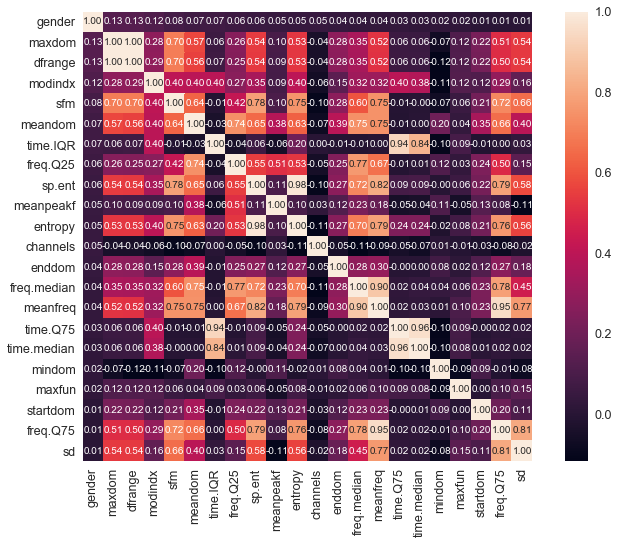

In [29]:
#Correlations map with the target variable
#saleprice correlation matrix
k = 22 #number of variables for heatmap
cols = corrmat.nlargest(k, 'gender')['gender'].index
cm = np.corrcoef(dataframe[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

Now we can see how entropy and sp.ent are highly correlated(0.98) and also freq.Q75 and meanfreq (0.95). We don't observe any other high correlations in the matrix.

The correlation of the features with the target variable is almost zero for all, they may be due to the problem being about classification and not regression.

We will get rid of sp.ent and freq.Q75 as we already have features with the information they give to us.


In [30]:
dataframe.drop('sp.ent',axis=1,inplace=True)
dataframe.drop('freq.Q75',axis=1,inplace=True)

Again another way to see the exact pearson correlation of the features with the target gender

In [31]:
dataframe.corr(method='pearson')['gender'].sort_values(ascending=False,axis=0)

gender         1.000000
maxdom         0.133544
dfrange        0.131629
modindx        0.115766
sfm            0.084689
meandom        0.071198
time.IQR       0.070878
freq.Q25       0.063397
meanpeakf      0.052162
entropy        0.046862
channels       0.046721
enddom         0.042496
freq.median    0.035509
meanfreq       0.035260
time.Q75       0.032293
time.median    0.025516
mindom         0.024881
maxfun         0.023392
startdom       0.012722
sd             0.005040
freq.IQR      -0.009544
minfun        -0.029357
time.Q25      -0.036121
time.ent      -0.040459
kurt          -0.083275
skew          -0.096922
meanfun       -0.226577
selec               NaN
dfslope             NaN
Name: gender, dtype: float64

We see again how our features don't present any high correlation with the target (again this may be due to the problem nature)

By last we want to check the missing data in our dataset, see how reliable our dataset is

In [32]:
#missing data
total = dataframe.isnull().sum().sort_values(ascending=False)
percent = (dataframe.isnull().sum()/dataframe.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
language,4559,0.053577
rateFormat,885,0.010400
fileType,580,0.006816
meanpeakf,0,0.000000
sd,0,0.000000
time.Q25,0,0.000000
time.median,0,0.000000
freq.IQR,0,0.000000
freq.Q25,0,0.000000
freq.median,0,0.000000


Seems like we wont have problems with this.

<a name=Categoricalfeatures></a>

### Categorical features
[Return to table of contents](#Indice)

Now we will now study the categorical features. Have in mind that the study will be different to the continuous due to the nature of the data.

In [33]:
categoricalFeatures

Index(['age', 'gender', 'language', 'dialect', 'fileType', 'rateFormat'], dtype='object')

Let's see how many values our categorical features have, we should group values in the extensive features and remove constant features.

In [34]:
for feature in categoricalFeatures:
    print("Unique values for feature: {0}".format(feature))
    print(dataframe[feature].value_counts())
    print()

Unique values for feature: age
Adult      69538
Youth      11789
adult       1926
Senior      1500
Select       270
youth         50
unknown       20
Name: age, dtype: int64

Unique values for feature: gender
0    72161
1    12932
Name: gender, dtype: int64

Unique values for feature: language
EN                                   80369
ENEnglish                              134
ENEnglishNLDutchDEGermanRURussian       31
Name: language, dtype: int64

Unique values for feature: dialect
AmericanEnglishn        45052
EuropeanEnglishn         9383
BritishEnglishn          8156
CanadianEnglishn         4369
Othern                   4162
AustralianEnglishn       3042
IndianEnglishn           2676
EnglishEnglishn          1053
isDutchn                 1014
AfricanEnglishn           807
ZealandEnglishn           749
othern                    608
Englishn                  540
AmericanEnglishrn         413
NorthernNJn               387
IrishEnglishn             331
GeneralAmericann          294
W

Age and dialect seem promising features but they have some problems we have to process: 

age: multiple values with the same meaning (let's map them)
dialect: too many possible values (in a lot of those values they have low occurrences number) so we will group them.

Language channel fileformat filetype has only one value (even if it's in different strings) so we will drop them.

In [35]:
#We will process this variables now and delete those that wont give us any usefull information

#Age will likely be a usefull feature as vocal voice changes through our years and gender, specially when being young or adult
dataframe['age'] = dataframe['age'].map({'Adult':'Adult','Youth':'Youth','adult':'Adult','Senior':'Senior', 'youth':'Youth'})

#Dialect may probably be a usefull feature for specific pronunciations but Im not as sure as with age. it has to many values, we will reduce them to the most frequent 10
mapTop = {}
top10 = dataframe['dialect'].value_counts()[:10]
for i in dataframe['dialect'].unique():
    if i in top10:
        mapTop[i]=i
    else:
        mapTop[i]='Othern'

dataframe['dialect'] = dataframe['dialect'].map(mapTop)

#Laguange only takes EN related values so we will drop it
dataframe.drop('language',axis=1,inplace = True)


#fileType only takes EN related values so we will drop it
dataframe.drop('fileType',axis=1,inplace = True)

#rateFormat only takes EN related values so we will drop it
dataframe.drop('rateFormat',axis=1,inplace = True)

#channels only takes EN related values so we will drop it
dataframe.drop('channels',axis=1,inplace = True)



After cleaning the features we can now procced to study age and dialect and see how they perform against the gender.

[Text(0,0,'Adult'), Text(0,0,'Youth'), Text(0,0,'Senior')]

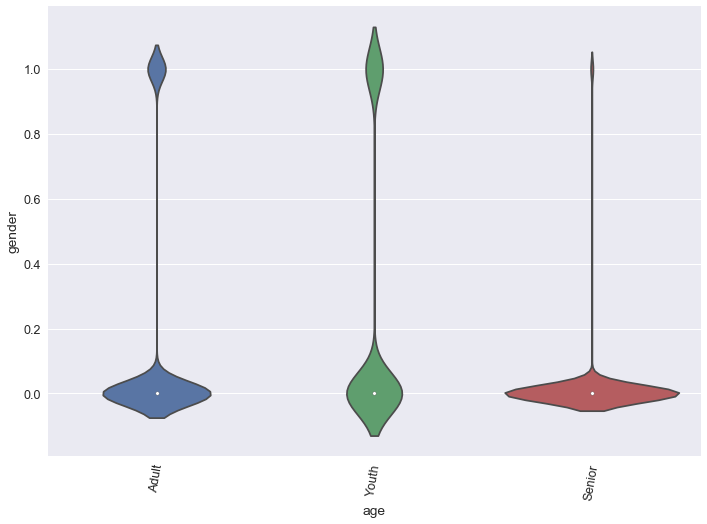

In [36]:
#Age
age = dataframe["age"].value_counts()
age_top_keys = list(age.keys())
condition_array = [False] * len(dataframe["age"])
for i in range(len(condition_array)):
    condition_array[i] = str(dataframe["age"].iloc[i]) in age_top_keys

g =sns.violinplot(x=dataframe["age"].loc[condition_array],y=dataframe["gender"].loc[condition_array])
g.set_xticklabels(g.get_xticklabels(),rotation=80)



We see how the 3 main values: adult, youth, senior take different shapes when comparing male and female in our violinplot, meaning that the age feature should provide us with some information about the gender.

[Text(0,0,'AmericanEnglishn'),
 Text(0,0,'CanadianEnglishn'),
 Text(0,0,'EnglishEnglishn'),
 Text(0,0,'AustralianEnglishn'),
 Text(0,0,'EuropeanEnglishn'),
 Text(0,0,'BritishEnglishn'),
 Text(0,0,'IndianEnglishn'),
 Text(0,0,'Othern'),
 Text(0,0,'isDutchn'),
 Text(0,0,'AfricanEnglishn')]

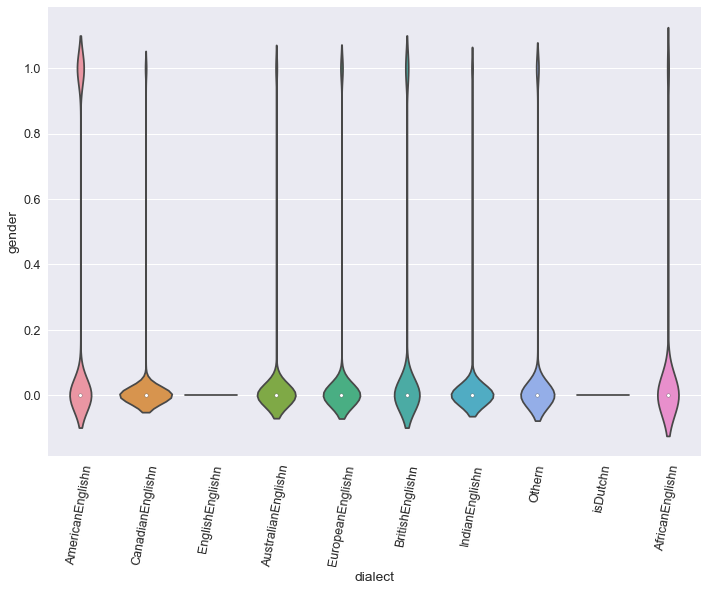

In [37]:
#Dialect
dialect = dataframe["dialect"].value_counts()
dialect_top_keys = list(dialect.keys())
condition_array = [False] * len(dataframe["dialect"])
for i in range(len(condition_array)):
    condition_array[i] = str(dataframe["dialect"].iloc[i]) in dialect_top_keys

g =sns.violinplot(x=dataframe["dialect"].loc[condition_array],y=dataframe["gender"].loc[condition_array])
g.set_xticklabels(g.get_xticklabels(),rotation=80)


With dialect we find the same as in age, different shapes when analyzing gender in each feature (but less prominent). We will still keep the feature

We now transform categorical features to one hot, this now can be done very fast thanks to pandas.get_dummies()




In [38]:

dataframe = pd.get_dummies(dataframe,prefix_sep ="-")
print('\nDataframe shape: {}'.format(dataframe.shape))


Dataframe shape: (85093, 41)


In [39]:
#We update columns list, now there are only continuous features as we have transformed categorial to one hot
continuousFeatures = dataframe.select_dtypes(include=['float64','int64']).columns

In [40]:
dataframe.columns

Index(['gender', 'selec', 'meanfreq', 'sd', 'freq.median', 'freq.Q25',
       'freq.IQR', 'time.median', 'time.Q25', 'time.Q75', 'time.IQR', 'skew',
       'kurt', 'time.ent', 'entropy', 'sfm', 'meanfun', 'minfun', 'maxfun',
       'meandom', 'mindom', 'maxdom', 'dfrange', 'modindx', 'startdom',
       'enddom', 'dfslope', 'meanpeakf', 'age-Adult', 'age-Senior',
       'age-Youth', 'dialect-AfricanEnglishn', 'dialect-AmericanEnglishn',
       'dialect-AustralianEnglishn', 'dialect-BritishEnglishn',
       'dialect-CanadianEnglishn', 'dialect-EnglishEnglishn',
       'dialect-EuropeanEnglishn', 'dialect-IndianEnglishn', 'dialect-Othern',
       'dialect-isDutchn'],
      dtype='object')

<a name=Preprocessing></a>
# Preprocessing
[Return to table of contents](#Indice)

<a name=Dataframeirregularities></a>

## Dataframe irregularities

We now apply some irregularities fixing methods for our dataset such as:

Cleaning features with >98% zeros, 100% nans, constant values or duplicated

In [41]:
#Remove features with a high % of zeros, >98%
zero_count = []
cols_to_drop = []
for col in dataframe.columns:
    aux=[i[1] for i in list(dataframe[col].value_counts().items()) if (i[0] == 0)]
    if aux!=[]:
        zero_count.append(aux[0])
        if (aux[0]>=dataframe.shape[0]*0.98):
            cols_to_drop.append(col)
    else:
        zero_count.append(0)
print('{0} features of {1} have zeroes in 99% or more samples.'.format(len([i for i in zero_count if i >= dataframe.shape[0] * 0.99]),dataframe.shape[1]))
print('{0} features of {1} have zeroes in 98% or more samples.'.format(len([i for i in zero_count if i >= dataframe.shape[0] * 0.98]),dataframe.shape[1]))
print('{0} features of {1} have zeroes in 97% or more samples.'.format(len([i for i in zero_count if i >= dataframe.shape[0] * 0.97]),dataframe.shape[1]))
print('{0} features of {1} have zeroes in 96% or more samples.'.format(len([i for i in zero_count if i >= dataframe.shape[0] * 0.96]),dataframe.shape[1]))
print('{0} features of {1} have zeroes in 95% or more samples.'.format(len([i for i in zero_count if i >= dataframe.shape[0] * 0.95]),dataframe.shape[1]))

#cols_to_drop = [col for col in X_train.columns[2:] if [i[1] for i in list(X_train[col].value_counts().items()) if i[0] == 0][0] >= 4459 * 0.98]
dataframe=dataframe.drop(cols_to_drop, axis=1)
print('Removing features with more than 98% zeroes:{0}'.format(cols_to_drop))
print('\nDataframe shape: {}'.format(dataframe.shape))

2 features of 41 have zeroes in 99% or more samples.
5 features of 41 have zeroes in 98% or more samples.
5 features of 41 have zeroes in 97% or more samples.
7 features of 41 have zeroes in 96% or more samples.
7 features of 41 have zeroes in 95% or more samples.
Removing features with more than 98% zeroes:['dfslope', 'age-Senior', 'dialect-AfricanEnglishn', 'dialect-EnglishEnglishn', 'dialect-isDutchn']

Dataframe shape: (85093, 36)


In [42]:
print('Removing features with more than 100% NaNs')
dataframe.dropna(axis=1, how='all', inplace=True)
print('\nDataframe shape: {}'.format(dataframe.shape))

Removing features with more than 100% NaNs

Dataframe shape: (85093, 36)


In [43]:
# remove constant features in the dataframe
nunique = dataframe.apply(pd.Series.nunique)
cols_to_drop = nunique[nunique == 1].index
        

dataframe.drop(cols_to_drop, axis=1, inplace=True)

print("Removed `{}` Constant features\n".format(len(cols_to_drop)))
print(cols_to_drop)
print('\nDataframe shape: {}'.format(dataframe.shape))

Removed `1` Constant features

Index(['selec'], dtype='object')

Dataframe shape: (85093, 35)


In [44]:
#Remove duplicated columns

colsToRemove = []
colsScaned = []
dupList = {}

columns = dataframe.columns

for i in range(len(columns)-1):
    v = dataframe[columns[i]].values
    dupCols = []
    for j in range(i+1,len(columns)):
        if np.array_equal(v, dataframe[columns[j]].values):
            colsToRemove.append(columns[j])
            if columns[j] not in colsScaned:
                dupCols.append(columns[j]) 
                colsScaned.append(columns[j])
                dupList[columns[i]] = dupCols
                
# remove duplicate columns in the training set
dataframe.drop(colsToRemove, axis=1, inplace=True) 

print("Removed `{}` Duplicate Columns\n".format(len(dupList)))
print(dupList)

print('\nDataframe shape: {}'.format(dataframe.shape))

Removed `0` Duplicate Columns

{}

Dataframe shape: (85093, 35)


In [45]:
#update column indices
continuousFeatures = dataframe.select_dtypes(include=['float64','int64']).columns
categoricalFeatures = dataframe.select_dtypes(include='object').columns

<a name=Preparethedata></a>

## Prepare the data
[Return to table of contents](#Indice)

<a name=Balancingdata></a>

### Balancing data

#### Upsample and downsampling

When balancing a dataset we can either upsample the minority (female in our case) or downsample the majority (male), when upsampling we could use oversampling methods such as SMOTE and ADASYN. 

In the other hand when we downsample the resultant set will be just a portion from the original one, having only original samples.

We will always choose to downsample if we have enough samples for our problem, in our case 12k samples seems fair enough.


In [46]:
# Separate majority and minority classes
df_majority = dataframe[dataframe.gender==0]
df_minority = dataframe[dataframe.gender==1]
 
# Upsample minority class, we will not be upsampling today 
#df_minority_upsampled = resample(df_minority, 
#                                 replace=True,     # sample with replacement
#                                 n_samples=len(dataframe.loc[dataframe['gender'] == 0]),    # to match majority class
#                                 random_state=17) # reproducible results
 
# Combine majority class with upsampled minority class
#dataframe_upsampled = pd.concat([df_majority, df_minority_upsampled])
 # Display new class counts
#dataframe_upsampled.gender.value_counts()

 
# Downsample majority class
df_majority_downsampled = resample(df_majority, 
                                 replace=False,    # sample without replacement
                                 n_samples=len(dataframe.loc[dataframe['gender'] == 1]),     # to match minority class
                                 random_state=17) # reproducible results
 
# Combine minority class with downsampled majority class
dataframe_downsampled = pd.concat([df_majority_downsampled, df_minority])
 
# Display new class counts
dataframe_downsampled.gender.value_counts()

1    12932
0    12932
Name: gender, dtype: int64

We now have a new balanced dataset **dataframe_downsampled** that comes from downsampling the original one

<a name=Expanding></a>

### Expanding the dataset with external sources

Another way to balance our dataset its to add samples from the minority set, we have found a dataset audio.csv in the internet https://www.kaggle.com/rohankale/voice-recognition where features are the same as the ones we obtained from the specan method in warbleR (but not the ones we took from the tgz files). Meaning that we will have to cut features from our original dataset in order to be able to concadenate this new dataset with ours. 

We will still have to downsample the minority class but our resultant number will be greater than before.

In [50]:
dfExtra = pd.read_csv('voice.csv')

print("Merging existing dataframe with new dataframe of shape{0}".format(dfExtra.shape))

dfExtra=dfExtra.rename(index=str,columns = { #Rename variables to allow concat
    'label':'gender',
    'median':'freq.median',
    'Q25':'time.Q25',
    'Q75':'time.Q75',
    'IQR':'time.IQR',
    'sp.ent':'time.ent',
    })


dfExtra.drop(['mode', 'centroid'],axis=1,inplace=True) # Drop variables not avaliable in our dataset
dfExtra['gender'] = dfExtra['gender'].map({'female': 1, 'male': 0}) #Encode the target variable

dataframe=dataframe[dfExtra.columns] #The two datasets now use same features

dfExtra=dfExtra.append(dataframe)

print("Columns for the extended dataframe{0}".format(dfExtra.columns))



#Downsample to the minority class
# Separate majority and minority classes
df_majority = dfExtra[dfExtra.gender==0]
df_minority = dfExtra[dfExtra.gender==1]

# Downsample majority class
df_majority_downsampled = resample(df_majority, 
                                 replace=False,    # sample without replacement
                                 n_samples=len(dfExtra.loc[dfExtra['gender'] == 1]),     # to match minority class
                                 random_state=17) # reproducible results

# Combine minority class with downsampled majority class
dfExtra_downsampled = pd.concat([df_majority_downsampled, df_minority])
 
# Display new class counts
print("New class balance:")
print(dfExtra_downsampled.gender.value_counts())

print('dfExtra_downsampled shape: {}'.format(dfExtra_downsampled.shape))

Merging existing dataframe with new dataframe of shape(3168, 21)
Columns for the extended dataframeIndex(['meanfreq', 'sd', 'freq.median', 'time.Q25', 'time.Q75', 'time.IQR',
       'skew', 'kurt', 'time.ent', 'sfm', 'meanfun', 'minfun', 'maxfun',
       'meandom', 'mindom', 'maxdom', 'dfrange', 'modindx', 'gender'],
      dtype='object')
New class balance:
1    14516
0    14516
Name: gender, dtype: int64
dfExtra_downsampled shape: (29032, 19)


We now added 1584 new elements at the cost of losing some features. 

From now on we will perform feature selection and model analysis for the two datasets **dataframe_downsampled** and **dfExtra_downsampled**, if at one moment we ensure that one of the two datasets it's better we will only continue with that one.

### Prepare splits for scoring without cross validation 

We now do the splits needed for training and testing purposes of all of our models when not using cv. Standard scaling has been applied to all the data.

Firstly the dataset_downsampled and dfExtra_downsampled will be split, then we will evaluate a feature extraction for our first dataset_downsampled as it counts with a larger number of features. To do so we will use 2 different tree models (extratrees and random forest) in which we can see the features that give us more importance when pruning.

We have chosen tree models for feature extraction rather than typical goodness of fit test such as two sample Kolmogorov–Smirnov test (where you can compare two series with the null hypothesis is that those two samples are drawn from the same distribution). The reason for this is that in our preliminary review of the dataset (see continuous variable analysis) we saw how the distributions of the features for male or female weren't that different, we were able to see some different behavior but overall they will always pass the K-S test. By letting tree models decide our top features we are choosing the features that contain more information regarding target=gender.

In [51]:
#Reduce df size for faster computs if you want
#dataframe_downsampled = dataframe_downsampled.sample(30000)
#dfExtra_downsampled = dfExtra_downsampled.sample(30000)


In [52]:
#dataframe_downsampled will be default name
train, test = train_test_split(dataframe_downsampled, test_size=0.2)

# Scale the data to be between -1 and 1

scaler = StandardScaler()
X = scaler.fit_transform(dataframe_downsampled.drop('gender',axis =1))


train_columns = dataframe_downsampled.drop('gender',axis =1).columns
y = dataframe_downsampled['gender']

X_train= scaler.transform(train.drop('gender',axis=1))
y_train=train['gender']

X_test= scaler.transform(test.drop('gender',axis=1))
y_test=test['gender']

#dfExtra_downsampled
train_Extra, test_Extra = train_test_split(dfExtra_downsampled, test_size=0.2)

# Scale the data to be between -1 and 1

scaler_Extra = StandardScaler()
X_Extra = scaler_Extra.fit_transform(dfExtra_downsampled.drop('gender',axis =1))

train_columns_Extra = dfExtra_downsampled.drop('gender',axis =1).columns
y_Extra = dfExtra_downsampled['gender']

X_train_Extra=scaler_Extra.transform(train_Extra.drop('gender',axis=1))
y_train_Extra=train_Extra['gender']

X_test_Extra=scaler_Extra.transform(test_Extra.drop('gender',axis=1))
y_test_Extra=test_Extra['gender']

<a name=Featureselection></a>

## Feature selection
[Return to table of contents](#Indice)

When looking to extract features from a dataset ideally we will only choose those who contain information regarding the target variable. Most common ways are:
    
* Study correlation between the target and the feature. #Done

* Study correlation between features and remove those very correlated(duplicated information) #Done

* Study distributions in the feature when splitting by target feature. #Done

* Apply decomposition techniques such as PCA were we convert a set of observations of possibly correlated variables(original dataset) into a set of values of linearly uncorrelated variables. #We won't be doing this technique now as we would like a model coming from original features to be able to provide insights into the features. But will include this in our possible improvements list 

* Fit models with the dataset and see which features provide you with the most information in the model.

We will now do the last point, we have chosen tree models (extra-trees and random forests) as they provide us with information scores for the features thanks to the model nature. We will compare the most important features of this models with the ones we have observed from our features before in their analysis.

##### We will only apply these methods to the dataframe_downsampled and not to the extended one as dfExtra_downsampled already counts with a lower number of features




### Dataframe_downsampled

#### ExtraTrees

In [53]:
# Build a forest and compute the feature importances, you can choose extratrees or randomforest up to you but this is faster
forest = ExtraTreesClassifier(n_estimators=10000,
                              random_state=0)

forest.fit(X, y)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]




In [54]:
# Print the feature ranking
print("Feature ranking with extratrees in dataframe_downsampled:")

for f in range(X.shape[1])[:30]:
    print("%d. feature %s (%f)" % (f + 1, train_columns[indices[f]], importances[indices[f]]))


Feature ranking with extratrees in dataframe_downsampled:
1. feature dialect-AmericanEnglishn (0.086183)
2. feature meanfun (0.071112)
3. feature meanpeakf (0.069824)
4. feature freq.Q25 (0.044148)
5. feature maxdom (0.039542)
6. feature dfrange (0.038773)
7. feature skew (0.037182)
8. feature freq.IQR (0.036502)
9. feature sfm (0.035984)
10. feature freq.median (0.034685)
11. feature entropy (0.034001)
12. feature sd (0.033965)
13. feature kurt (0.032711)
14. feature meandom (0.032582)
15. feature time.ent (0.029664)
16. feature modindx (0.029617)
17. feature meanfreq (0.029416)
18. feature time.IQR (0.026267)
19. feature time.Q25 (0.025976)
20. feature mindom (0.024689)
21. feature startdom (0.024182)
22. feature minfun (0.022991)
23. feature time.Q75 (0.022970)
24. feature time.median (0.022602)
25. feature enddom (0.022500)
26. feature dialect-EuropeanEnglishn (0.017188)
27. feature age-Youth (0.014286)
28. feature age-Adult (0.012213)
29. feature dialect-CanadianEnglishn (0.011985

It's good to see that the categorical features are in this list, this means that the extra feature extraction from the files its completely worth and that dataframe_downsampled will probably be better than dfExtra.

### dfextra version




In [55]:
forest = ExtraTreesClassifier(n_estimators=1000,
                              random_state=0)

forest.fit(X_Extra, y_Extra)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

In [56]:
# Print the feature ranking
print("Feature ranking with extratrees in dfExtra_downsampled:")

for f in range(X.shape[1])[:18]:
    print("%d. feature %s (%f)" % (f + 1, train_columns_Extra[indices[f]], importances[indices[f]]))


Feature ranking with extratrees in dfExtra_downsampled:
1. feature meanfun (0.138697)
2. feature maxdom (0.059346)
3. feature sd (0.058072)
4. feature skew (0.057626)
5. feature dfrange (0.057558)
6. feature sfm (0.056116)
7. feature freq.median (0.055466)
8. feature meandom (0.055100)
9. feature time.ent (0.054338)
10. feature modindx (0.053458)
11. feature time.Q25 (0.053063)
12. feature time.IQR (0.052593)
13. feature meanfreq (0.051773)
14. feature kurt (0.050748)
15. feature minfun (0.045010)
16. feature mindom (0.043664)
17. feature time.Q75 (0.043460)
18. feature maxfun (0.013914)


#### RandomForest

In [57]:
#Feature selection with random forest

clf = RandomForestClassifier(n_estimators=1000, random_state=0, n_jobs=-1)
clf.fit(X_train, y_train)

features = train_columns
importances = clf.feature_importances_
indices = np.argsort(importances)

    




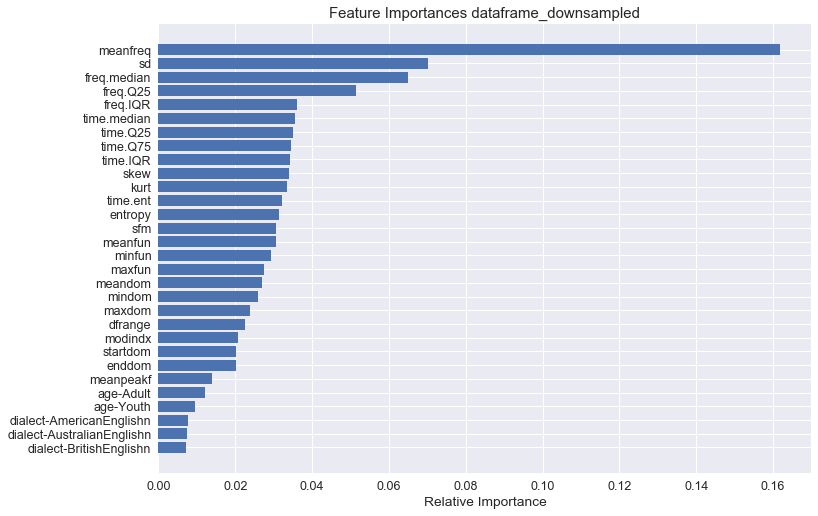

In [58]:
#Feature importance chart, just top 30
importances20 = np.array(sorted(importances, reverse=True)[:30])
indices20 = np.argsort(importances20)

top20_RF_dataframe_downsampled = [features[i] for i in indices20]

plt.title('Feature Importances dataframe_downsampled')
plt.barh(range(len(indices20)), importances20[indices20], align='center')
plt.yticks(range(len(indices20)),top20_RF_dataframe_downsampled)
plt.xlabel('Relative Importance')
plt.show()



Results from our random forest and extra-trees are almost similar but we can see how rf gives us some features labeled as important that we already saw on feature analysis, we will keep the top 20 features from rf to build a new dataset. 

Doing data splits for the new dataframe, standard scaling it's being used.

In [59]:
#We create now a new dataset with a selection of the best 20 features, we will test it agains others in SVM to choose the best one and then move to better models with it
#dataframe_downsampled will be default name

top20_RF_dataframe_downsampled.append('gender')
train_reduced, test_reduced = train_test_split(dataframe_downsampled[top20_RF_dataframe_downsampled], test_size=0.2)

# Scale the data to be between -1 and 1

scaler_reduced = StandardScaler()
X_reduced = scaler_reduced.fit_transform(dataframe_downsampled[top20_RF_dataframe_downsampled].drop('gender',axis =1))


train_columns_reduced = dataframe_downsampled[top20_RF_dataframe_downsampled].drop('gender',axis =1).columns
y_reduced = dataframe_downsampled[top20_RF_dataframe_downsampled]['gender']

X_train_reduced= scaler_reduced.transform(train_reduced.drop('gender',axis=1))
y_train_reduced=train_reduced['gender']

X_test_reduced= scaler_reduced.transform(test_reduced.drop('gender',axis=1))
y_test_reduced=test_reduced['gender']


### dFextra_downsampled

We won't be selecting features from dfExtra_downsampled dataset as they are already less than the original dataset and we don't expect better performance if we do. But for the sake of knowledge, we can show the top20 features with the chosen model for feature extraction(rf) and see if they are similar to dataframe_downsampled_reduced.

In [60]:
clf = RandomForestClassifier(n_estimators=10000, random_state=0, n_jobs=-1)
clf.fit(X_train_Extra, y_train_Extra)

features = train_columns_Extra
importances = clf.feature_importances_
indices = np.argsort(importances)

  

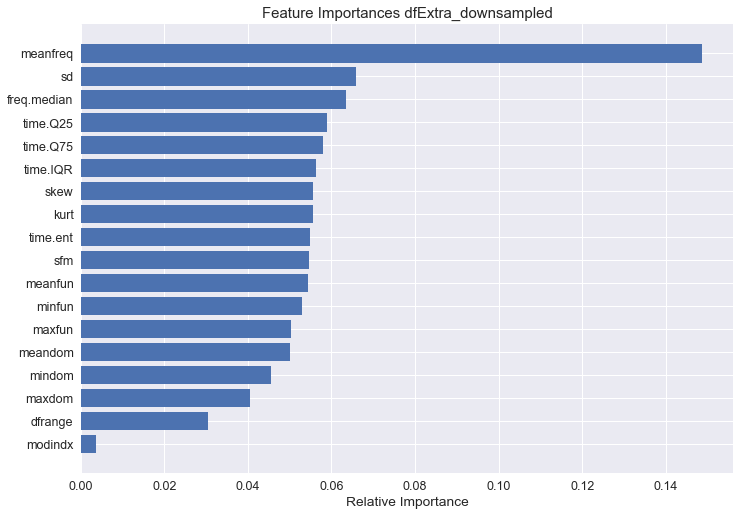

In [61]:
from matplotlib import cm
#Feature importance chart, just top 30
importances20 = np.array(sorted(importances, reverse=True)[:30])
indices20 = np.argsort(importances20)

top20_RF_dfExtra_downsampled = [features[i] for i in indices20]

plt.set_cmap('hot')
plt.title('Feature Importances dfExtra_downsampled')
plt.barh(range(len(indices20)), importances20[indices20], align='center',)
plt.yticks(range(len(indices20)), top20_RF_dfExtra_downsampled)
plt.xlabel('Relative Importance')
plt.show()

Important features for this dataset are very similar than the ones from the original one but with the difference that ***dataframe_downsampled*** has age and dialect (this may lead the original dataset to better results as this variables represent information dfExtra doesn't have).

<a name=Buildingthemodel></a>

# Building the model
[Return to table of contents](#Indice)

We now proceed to study several models for our dataset: SVM (different kernels) XGBoost, DNN. We know that there are a high number of models we could try too but we find these 3 models representative to the algorithm they use (kernels, trees & Gradient boosting, deep learning). More models such as RF, Gradient Boosting, Logistic Regression could be studied but we have limited time and hence we will focus on the best of their field.

<a name=Choosingthemetricforourmodels></a>

## Choosing the metric for our models

There are several metrics used for binary classification problems but choosing the right metric depends on the purpose and nature of our model. From what we know for the problem avoiding false negatives is not more important than getting true positives(that would be the case if you were trying to detect people getting to rob in a building, where you prefer false positives rather than false negatives), in our problem false negative and false positive have the same weight (we can't say the opposite if we don't know this models application for real life) so we will use standard accuracy where we maximize the true positives.

Although they are widely used in binary classification problems, metrics like AUC (true positive rate against false positive rate) or others metrics like F-1 wouldn't make sense in this specific context.

We will use cross-validation in 5 blocks in every model we are able to as cv provides us with a more robust score. Thanks to cv=5 we can achieve an 80% training set with a 100% test set.

<a name=SVM></a>

## SVM

### SVM kernels, without cv

In [50]:
#Trying different kernels
print("dataframe_downsampled scores")
svc=SVC(kernel='linear')
svc.fit(X_train,y_train)
y_pred=svc.predict(X_test)
print('--Linear kernel accuracy_score: {0}'.format(metrics.accuracy_score(y_test,y_pred)))

svc=SVC(kernel='rbf')
svc.fit(X_train,y_train)
y_pred=svc.predict(X_test)
print('--Radial basis function accuracy_score: {0}'.format(metrics.accuracy_score(y_test,y_pred)))

svc=SVC(kernel='poly')
svc.fit(X_train,y_train)
y_pred=svc.predict(X_test)
print('--Polinomial accuracy_score: {0}'.format(metrics.accuracy_score(y_test,y_pred)))

#Trying different kernels
print(" \ndataframe_downsampled_reduced scores")
svc=SVC(kernel='linear')
svc.fit(X_train_reduced,y_train_reduced)
y_pred=svc.predict(X_test_reduced)
print('--Linear kernel accuracy_score:{0}'.format(metrics.accuracy_score(y_test_reduced,y_pred)))

svc=SVC(kernel='rbf')
svc.fit(X_train_reduced,y_train_reduced)
y_pred=svc.predict(X_test_reduced)
print('--Radial basis function accuracy_score: {0}'.format(metrics.accuracy_score(y_test_reduced,y_pred)))

svc=SVC(kernel='poly')
svc.fit(X_train_reduced,y_train_reduced)
y_pred=svc.predict(X_test_reduced)
print('--Polinomial accuracy_score: {0}'.format(metrics.accuracy_score(y_test_reduced,y_pred)))

print(" \ndfExtra_downsampled scores:")

svc=SVC(kernel='linear')
svc.fit(X_train_Extra,y_train_Extra)
y_pred=svc.predict(X_test_Extra)
print('--Linear kernel accuracy_score: {0}'.format(metrics.accuracy_score(y_test_Extra,y_pred)))

svc=SVC(kernel='rbf')
svc.fit(X_train_Extra,y_train_Extra)
y_pred=svc.predict(X_test_Extra)
print('--Radial basis function  accuracy_score: {0}'.format(metrics.accuracy_score(y_test_Extra,y_pred)))

svc=SVC(kernel='poly')
svc.fit(X_train,y_train)
y_pred=svc.predict(X_test)
print('--Polinomial accuracy_score: {0}'.format(metrics.accuracy_score(y_test,y_pred)))

dataframe_downsampled scores
--Linear kernel accuracy_score: 0.7575874734196791
--Radial basis function accuracy_score: 0.8465107287840712
--Polinomial accuracy_score: 0.8043688381983375
 
dataframe_downsampled_reduced scores
--Linear kernel accuracy_score:0.7436690508409047
--Radial basis function accuracy_score: 0.8424511888652619
--Polinomial accuracy_score: 0.8171273922288808
 
dfExtra_downsampled scores:
--Linear kernel accuracy_score: 0.691751334596177
--Radial basis function  accuracy_score: 0.7819872567590839
--Polinomial accuracy_score: 0.8043688381983375


### SVM with CV

In [0]:
#SVM with cross validation
from sklearn.cross_validation import cross_val_score

dataframe_score = []
dfExtra_score = []
dataframe_reduced_score = []

print("dataframe_downsampled cv accuracy scores:")
svc=SVC(kernel='linear')
scores = cross_val_score(svc, X, y, cv=5, scoring='accuracy') #cv is cross validation
dataframe_score.append(scores.mean())
print(" Linear CV accuracy:{0}".format(scores.mean()))

svc=SVC(kernel='rbf')
scores = cross_val_score(svc, X, y, cv=5, scoring='accuracy') #cv is cross validation
dataframe_score.append(scores.mean())
print(" Radial basis CV accuracy:{0}".format(scores.mean()))

svc=SVC(kernel='poly')
scores = cross_val_score(svc, X, y, cv=5, scoring='accuracy') #cv is cross validation
dataframe_score.append(scores.mean())
print(" Polinomial CV accuracy:{0}".format(scores.mean()))

print("dataframe_downsampled_reduced cv accuracy scores:")
svc=SVC(kernel='linear')
scores = cross_val_score(svc, X_reduced, y_reduced, cv=5, scoring='accuracy') #cv is cross validation
dataframe_reduced_score.append(scores.mean())
print(" Linear CV accuracy:{0}".format(scores.mean()))

svc=SVC(kernel='rbf')
scores = cross_val_score(svc, X_reduced, y_reduced, cv=10, scoring='accuracy') #cv is cross validation
dataframe_reduced_score.append(scores.mean())
print(" Radial basis CV accuracy:{0}".format(scores.mean()))

svc=SVC(kernel='poly')
scores = cross_val_score(svc, X_reduced, y_reduced, cv=5, scoring='accuracy') #cv is cross validation
dataframe_reduced_score.append(scores.mean())
print(" Polinomial CV accuracy:{0}".format(scores.mean()))

print("dfExtra_downsampled cv accuracy scores:")
svc=SVC(kernel='linear')
scores = cross_val_score(svc, X_Extra, y_Extra, cv=5, scoring='accuracy') #cv is cross validation
dfExtra_score.append(scores.mean())
print(" Linear CV accuracy:{0}".format(scores.mean()))

svc=SVC(kernel='rbf')
scores = cross_val_score(svc, X_Extra, y_Extra, cv=5, scoring='accuracy') #cv is cross validation
dfExtra_score.append(scores.mean())
print(" Radial basis CV accuracy:{0}".format(scores.mean()))

svc=SVC(kernel='poly')
scores = cross_val_score(svc, X_Extra, y_Extra, cv=5, scoring='accuracy') #cv is cross validation
dfExtra_score.append(scores.mean())
print(" Polinomial CV accuracy:{0}".format(scores.mean()))

dataframe_downsampled cv accuracy scores:
 Linear CV accuracy:0.7434328347504277
 Radial basis CV accuracy:0.8158118677314897
 Polinomial CV accuracy:0.7804695297828876
dataframe_downsampled_reduced cv accuracy scores:
 Linear CV accuracy:0.7402230952304107
 Radial basis CV accuracy:0.8119841890287853
 Polinomial CV accuracy:0.788745336618171
dfExtra_downsampled cv accuracy scores:
 Linear CV accuracy:0.6721621404825778
 Radial basis CV accuracy:0.725452143767099
 Polinomial CV accuracy:0.6888040783120979


Let's print the CV accuracy scores and see which dataset of the three we are using its better.

<Figure size 7200x7200 with 0 Axes>

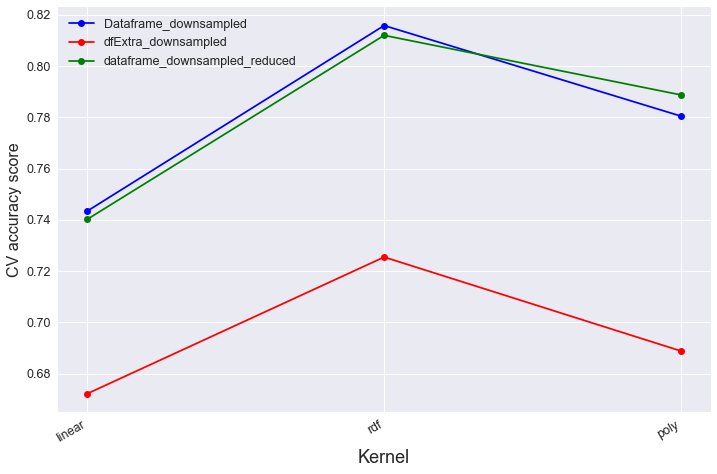

In [0]:
data = pd.DataFrame({"dataframe_downsampled":dataframe_score, "dfExtra_downsampled":dfExtra_score,"Kernel":["linear","rbf","poly"]})
kernel = ["linear","rdf","poly"]
df1 = pd.DataFrame({"kernel":kernel, "score" : dataframe_score})
df2 = pd.DataFrame({"kernel":kernel, "score" : dfExtra_score})
df3 = pd.DataFrame({"kernel":kernel, "score" : dataframe_reduced_score})

plt.figure(figsize=(100,100))

f, ax = plt.subplots(1, 1)
x_col='Kernel'
y_col = 'Accuracy score'

ax.plot_date(df1.kernel, df1["score"], color="blue", label="Dataframe_downsampled", linestyle="-")
ax.plot_date(df2.kernel, df2["score"], color="red", label="dfExtra_downsampled", linestyle="-")
ax.plot_date(df3.kernel, df3["score"], color="green", label="dataframe_downsampled_reduced", linestyle="-")

ax.legend()
plt.xlabel('Kernel', fontsize=18)
plt.ylabel('CV accuracy score', fontsize=16)
plt.gcf().autofmt_xdate()
plt.show()

Seems like radial basis function performs the best in the three datasets, with the top accuracy at the ***dataframe_downsampled*** dataset.

**dataframe_reduced_score** and ***dataframe_downsampled*** have very similar results so we are not able to select one right now, let's see their performance in XGBoost and decided which dataset use to tune parameters and DNN.





We decided to go with ***dataframe_downsampled*** for next models and parameter tunning due to its categorical features as an accuracy score doesn't give us enough reason to decide. This is subject to change depending on the project purposes and the available features in real life, now we don't have enough information to decide.

<a name=XGBoost></a>

## XGBoost with cv

We will use xgboost with the best parameters I could decide by my own judge taking into account parameters impact on the model for our problem.

In [0]:
#Out of the box model with start parameters
  #Perforing grid search

# xgboost model dataframe_downsampled
xgtrain = xgb.DMatrix(X, label=y)
clf = xgb.XGBClassifier(missing=9999999999,
                max_depth = 7,
                n_estimators=700,
                learning_rate=0.1, 
                nthread=4,
                subsample=1.0,
                colsample_bytree=0.5,
                min_child_weight = 3,
                seed=17)
xgb_param = clf.get_xgb_params()
##do cross validation
cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=5000, nfold=5, metrics=['error'],
     early_stopping_rounds=50, stratified=True, seed=17)
print('Overall accuracy for xgboost dataframe_downsampled:: {0}'.format(1-cvresult['test-error-mean'].values[-1]))

# xgboost model dataframe_downsampled
xgtrain = xgb.DMatrix(X_reduced, label=y_reduced)
clf = xgb.XGBClassifier(missing=9999999999,
                max_depth = 7,
                n_estimators=700,
                learning_rate=0.1, 
                nthread=4,
                subsample=1.0,
                colsample_bytree=0.5,
                min_child_weight = 3,
                seed=17)
xgb_param = clf.get_xgb_params()
##do cross validation
cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=5000, nfold=15, metrics=['error'],
     early_stopping_rounds=50, stratified=True, seed=17)
print('Overall accuracy for xgboost dataframe_downsampled_reduced: {0}'.format(1-cvresult['test-error-mean'].values[-1]))


# xgboost model dfExtra_downsampled
xgtrain = xgb.DMatrix(X_Extra, label=y_Extra)
clf = xgb.XGBClassifier(missing=9999999999,
                max_depth = 7,
                n_estimators=700,
                learning_rate=0.1, 
                nthread=4,
                subsample=1.0,
                colsample_bytree=0.5,
                min_child_weight = 3,
                seed=17)
xgb_param = clf.get_xgb_params()
##do cross validation
cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=5000, nfold=5, metrics=['error'],
     early_stopping_rounds=50, stratified=True, seed=17)
print('Overall accuracy for xgboost dfExtra_downsampled: {0}'.format(1-cvresult['test-error-mean'].values[-1]))


Overall accuracy for xgboost dataframe_downsampled:: 0.8925147999999999
Overall accuracy for xgboost dataframe_downsampled_reduced: 0.8915488666666667
Overall accuracy for xgboost dfExtra_downsampled: 0.8232297333333334


<a name=Tuningthemodelparameters></a>

## Tuning the model parameters
[Return to table of contents](#Indice)

SVM models take only one parameter and we already know the optimal range of values for the three different kernels(Thanks to the previous models) so we could find their optimal values by hand (using plots) or using a simple grid search algorithm from the package sklearn.

We present both approaches here.

#### NOTE: This part it's not executed for its required computing time but we provide the code necessary for it.

<a name=SVMtuning></a>

### SVM

#### Linear kernel

In [0]:
'''
The C parameter tells the SVM optimization how much you want to avoid misclassifying each training example. 
For large values of C, the optimization will choose a smaller-margin hyperplane if that hyperplane does a better job of getting all the training points classified correctly. Conversely,
a very small value of C will cause the optimizer to look for a larger-margin separating hyperplane,
even if that hyperplane misclassifies more points.
'''
C_range=list(range(1,26))

acc_score=[]
for c in C_range:
    svc = SVC(kernel='linear', C=c)
    scores = cross_val_score(svc, X, y, cv=5, scoring='accuracy')
    acc_score.append(scores.mean())

plt.plot(C_range,acc_score)
plt.xticks(np.arange(0,27,2))
plt.xlabel('Value of C for SVC, linear')
plt.ylabel('Cross-Validated Accuracy')

We see higher scores with C between X and Y, lets find the optima C in that space

In [0]:
#Lets explore now the range where the accuracy was higher
C_range=list(np.arange(0.1,6,0.1))
acc_score=[]
for c in C_range:
    svc = SVC(kernel='linear', C=c)
    scores = cross_val_score(svc, X, y, cv=5, scoring='accuracy')
    acc_score.append(scores.mean())

plt.plot(C_range,acc_score)
plt.xticks(np.arange(0.0,6,0.3))
plt.xlabel('Value of C for SVC ')
plt.ylabel('Cross-Validated Accuracy')

In [0]:
#Comentar que cojemos el maximo

#### Radial basis function kernel

In [0]:
'''
Technically, the gamma parameter is the inverse of the standard deviation of the RBF kernel (Gaussian function),
which is used as similarity measure between two points. Intuitively, a small gamma value define a Gaussian function with a large variance. In this case, two points can be considered similar even if are far from each other. In the other hand, a large gamma value means define a Gaussian function with a small variance and in this case, 
two points are considered similar just if they are close to each other
'''

gamma_range=[0.0001,0.001,0.01,0.1,1,10,100]
acc_score=[]
for g in gamma_range:
    svc = SVC(kernel='rbf', gamma=g)
    scores = cross_val_score(svc, X, y, cv=5, scoring='accuracy')
    acc_score.append(scores.mean())
    
plt.plot(gamma_range,acc_score)
plt.xlabel('Value of gamma for SVC ')
plt.xticks(np.arange(0.0001,100,5))
plt.ylabel('Cross-Validated Accuracy')

In [0]:
#Lets explore now the range where the accuracy was higher
gamma_range=[0.0001,0.001,0.01,0.1,0.2]
acc_score=[]
for g in gamma_range:
    svc = SVC(kernel='rbf', gamma=g)
    scores = cross_val_score(svc, X, y, cv=5, scoring='accuracy')
    acc_score.append(scores.mean())
print(acc_score)  

plt.plot(gamma_range,acc_score)
plt.xlabel('Value of gamma for SVC ')
plt.ylabel('Cross-Validated Accuracy')

#### Polinomial kernel

In [0]:
degree=[1,1.5,2,2.5,3]
acc_score=[]
for d in degree:
    svc = SVC(kernel='poly', degree=d)
    scores = cross_val_score(svc, X, y, cv=5, scoring='accuracy')
    acc_score.append(scores.mean())
print(acc_score)  

plt.plot(degree,acc_score,color='r')
plt.xlabel('degrees for SVC ')
plt.ylabel('Cross-Validated Accuracy')


In [0]:
#Lets explore now the range where the accuracy was higher
degree=list(np.arange(1,3,0.1))
acc_score=[]
for d in degree:
    svc = SVC(kernel='poly', degree=d)
    scores = cross_val_score(svc, X, y, cv=5, scoring='accuracy')
    acc_score.append(scores.mean())

plt.plot(degree,acc_score)
plt.xticks(np.arange(1,3,0.3))
plt.xlabel('degrees for SVC ')
plt.ylabel('Cross-Validated Accuracy')

####  Grid search to find the best parameters

Another way to tune hyperparameters would be grid search

In [0]:
svm= SVC()

tuned_parameters = {
 'C': list(np.arange(0.1,6,0.1)) , 'kernel': ['linear'], 'gamma': [0.0001,0.001,0.01,0.1,0.2], 'kernel': ['rbf'],
 'degree': [1,1.5,2,2.5,3] ,'kernel':['poly']
                   }



model_svm = GridSearchCV(svm, tuned_parameters,cv=5,scoring='accuracy',n_jobs=4) #allow parallelization

In [0]:
model_svm.fit(X_train, y_train)
print("Top accuracy: {0} with parameters: {1}".format(model_svm.best_score_.model_svm.best_params_))

<a name=XGBoosttuning></a>

### XGBoost

XGBoost is a great gradient boosted trees algorithm but unlike SVM it's very difficult to evaluate its optimal parameters due to their higher count. The space created by all the possible arguments is huge and we don't know its structure or how the parameters interact with each other in this space to get a better score. Due to this new difficulty, we present a new optimization technique Bayes Optimization, this technique is built to optimize black-box problems as the one we are against right now. Bayes-opt will get us a huge improvement if the parameters follow a normal distribution for f(x)

We will use the python package BayesianOptimization(more at https://github.com/fmfn/BayesianOptimization), defining the function to optimize the xgboost cross-validated training and scoring and the parameters being all possible xgboost parameters.

#### Tunning all parameters with bayes_opt

In [0]:
#We now tune parameters, we will use bayesian opt and not grid search due to the large ammount of parameters for xgboost
xgtrain = xgb.DMatrix(X_train, label=y_train)


def xgb_evaluate(min_child_weight,
                 colsample_bytree,
                 max_depth,
                 subsample,
                 gamma,
                 alpha):

    params['min_child_weight'] = int(min_child_weight)
    params['colsample_bytree'] = max(min(colsample_bytree, 1), 0)
    params['max_depth'] = int(max_depth)
    params['subsample'] = max(min(subsample, 1), 0)
    params['gamma'] = max(gamma, 0)
    params['alpha'] = max(alpha, 0)


    cv_result = xgb.cv(params, xgtrain, num_boost_round=100, nfold=5,
             seed=random_state,
             callbacks=[xgb.callback.early_stop(5)])
    return 1-cv_result['test-error-mean'].values[-1]





random_state = 17
num_iter = 50
init_points = 25
params = {
    'eta': 0.1,
    'silent': 1,
    'nthread':4
    'eval_metric': 'error',
    'verbose_eval': False,
    'seed': 17,
    'learning_rate'=0.1
}

xgbBO = BayesianOptimization(xgb_evaluate, {'min_child_weight': (1, 20),
                                            'colsample_bytree': (0.1, 1),
                                            'max_depth': (5, 20),
                                            'subsample': (0.5, 1),
                                            'gamma': (0, 15),
                                            'alpha': (0, 15),
                                            })

xgbBO.maximize(init_points=init_points, n_iter=num_iter)

print(xgbBO.res['max'])


<a name=DNN></a>
## DNN
[Return to table of contents](#Indice)

In this section two deep learning models are presented, each one of them with its pros and cons.

Due to the binary classification problem, we encounter our activation function for inner layers will be relu and sigmoid for the output layer (the output represents the probability of a test sample to be a specific gender). The loss function would be sigmoid_cross_entropy_with_logits or binary_crossentropy and the optimizer its Adam with learning rate decay.

In [0]:
#Splits for testing our DNN performance evaluation, some tuning will be done so we need two non-training sets (one will be biased by the results from tuning)
#y_test = y_test.values
aux =len(y_test)
test_y = y_test[:(aux//2)]
validation_y = y_test[(aux//2):]
aux=len(X_test)
test_x= X_test[:(aux//2)]
validation_x = X_test[(aux//2):]

### Easy implementation

Now we present an easy ready to go DNN with keras, this can be achieved with tf.estimators too but we went with keras now thanks to its binary_crossentropy loss function which has always performed outstandingly for us in binary classification problems. Same activation functions as we explained before.

In [0]:

def create_model():
    model = Sequential()
    opt = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
    model.add(Dense(60, input_dim=X.shape[1], kernel_initializer='normal', activation='relu'))
    model.add(Dense(30, input_dim=60, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal', activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

estimator = KerasClassifier(build_fn=create_model, epochs=70, batch_size=5, verbose=1)
#kfolds = StratifiedKFold(5)
estimator.fit(X_train,y_train,validation_data=(validation_x,validation_y))
result=estimator.score(test_x,test_y)
print("Test Results: {0}".format(result.mean()))

Train on 20691 samples, validate on 2587 samples
Epoch 1/70
20691/20691 [==============================] - 14s 667us/step - loss: 5.7159 - acc: 0.6190 - val_loss: 3.5502 - val_acc: 0.7418
Epoch 2/70
20691/20691 [==============================] - 12s 559us/step - loss: 3.1153 - acc: 0.7579 - val_loss: 2.7008 - val_acc: 0.7762
Epoch 3/70
20691/20691 [==============================] - 12s 562us/step - loss: 2.3846 - acc: 0.7784 - val_loss: 1.9642 - val_acc: 0.7932
Epoch 4/70
20691/20691 [==============================] - 12s 557us/step - loss: 1.6996 - acc: 0.7838 - val_loss: 1.4244 - val_acc: 0.7754
Epoch 5/70
20691/20691 [==============================] - 9s 456us/step - loss: 1.2058 - acc: 0.7875 - val_loss: 1.0574 - val_acc: 0.7855
Epoch 6/70
20691/20691 [==============================] - 10s 485us/step - loss: 0.7811 - acc: 0.7921 - val_loss: 0.6505 - val_acc: 0.7913
Epoch 7/70
20691/20691 [==============================] - 8s 384us/step - loss: 0.5497 - acc: 0.8020 - val_loss: 0.490

Our model gets 0.85~0.86 accuracy for validation set and 0.85% for the test set. The reason to use two non-training sets its that we actually tuned the parameters of our DNN(just a few runs) so if we were only using one set to evaluate our model it could be slightly biased(because we used to tune the model). So we tuned the parameters with validation_set and the final and independent score comes from the test_set at 0.85% accuracy.

We can appreciate some overfitting in the model even if validation accuracy doesn't decrease too much(less than 1%). This should be studied when more time is available, even considering CV if the power is available.

### Basic neural network step by step


In this section, a basic DNN model with 2 layers (more were tested but this performed the best) is presented. Here the optimizer is sigmoid_cross_entropy_with_logits as tf hasn't implemented binary-cross-entropy yet (we could implement it by ourselves but it requires time and this assignment has a deadline). Dropout has been applied to our layers in order to give it more consistency and help avoiding overfitting. 

We will train for 1000 epochs and the data will be given in batches. In order to avoid overfitting, we should choose the epoch were test accuracy remains the same and training accuracy grows alone.

In [0]:
#Transform y to (-1,2) so each class has it's 'identifier' and the nn can have output 2 

y_train= (y_train[:,None] != np.arange(2)).astype(int)
test_y= (test_y[:,None] != np.arange(2)).astype(int)
validation_y=(validation_y[:,None] != np.arange(2)).astype(int)


In [0]:
#Easy wrapper for building layers
def layer(input, n_input, n_output, name='hidden_layer'):
    W = tf.Variable(tf.truncated_normal([n_input,n_output], stddev=0.1), name='W')
    B = tf.Variable(tf.constant(0.1, dtype=tf.float32, shape=[n_output]), name='B')
    return tf.add(tf.matmul(input,W), B)

# Buildng the model
x = tf.placeholder(tf.float32, shape=[None, X_train.shape[1]], name="x")
y = tf.placeholder(tf.float32, shape=[None, 2], name="z")

hidden_1 = tf.nn.relu(layer(x, X_train.shape[1], 60, 'hidden_layer_1'))
hidden_1_dropout = tf.nn.dropout(hidden_1,keep_prob=0.9)
hidden_2 = tf.nn.relu(layer(hidden_1_dropout, 60, 30, 'hidden_layer_2'))
hidden_2_dropout = tf.nn.dropout(hidden_2,keep_prob=0.9)
#hidden_3 = tf.nn.relu(layer(hidden_2_dropout, 10, 7, 'hidden_layer_3'))
#hidden_3_dropout = tf.nn.dropout(hidden_3,keep_prob=0.9)
#hidden_4 = tf.nn.relu(layer(hidden_3_dropout, 7, 5, 'hidden_layer_4'))
#hidden_4_dropout = tf.nn.dropout(hidden_4,keep_prob=0.9)
output = tf.nn.sigmoid(layer(hidden_2_dropout, 30, 2, 'output'))

# Calculating loss function (sigmoid-cross-entropy)
loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=output, labels=y), name='xent')

# Training
optimizer = tf.train.AdamOptimizer(learning_rate=0.001,
    beta1=0.9, #betas for learning rate decay
    beta2=0.999,
    epsilon=1e-08,
    use_locking=False,
    name='Adam'
)
train = optimizer.minimize(loss)

# Accuracy
correct_prediction = tf.equal(tf.argmax(output, 1), tf.argmax(y, 1), name="correct_prediction")
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32), name="accuracy")

In [0]:

sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)

num_epochs = 1000
batch_size = 1024 #power of 2 is more efficient
train_size = X_train.shape[0]

for epoch in range(num_epochs):
    avg_accuracy = 0.0
    total_batches = int(train_size // batch_size)
    for step in range(total_batches):
        offset = (step * batch_size) % train_size
        batch_data = X_train[offset:(offset+batch_size),:]
        batch_labels = y_train[offset:(offset+batch_size)]
        _, ac = sess.run([train, accuracy], feed_dict={x: batch_data, y: batch_labels})
        avg_accuracy += ac / total_batches
    validation_accuracy = sess.run([accuracy], feed_dict= {x: validation_x, y: validation_y})
    if epoch % 50 == 0:
        print("Epoch:{} training_accuracy={}".format(epoch+1,avg_accuracy))
        print("Epoch:{} validation_accuracy={}".format(epoch+1,validation_accuracy))

validation_accuracy = sess.run([accuracy], feed_dict= {x: test_x, y: test_y})
print("Final test results {0}".format(validation_accuracy))

Epoch:1 training_accuracy=0.588671875
Epoch:1 validation_accuracy=[0.6810978]
Epoch:51 training_accuracy=0.8298828125
Epoch:51 validation_accuracy=[0.8330112]
Epoch:101 training_accuracy=0.847021484375
Epoch:101 validation_accuracy=[0.8453807]
Epoch:151 training_accuracy=0.8592773437500003
Epoch:151 validation_accuracy=[0.8519521]
Epoch:201 training_accuracy=0.8654296875
Epoch:201 validation_accuracy=[0.86122924]
Epoch:251 training_accuracy=0.8677734374999998
Epoch:251 validation_accuracy=[0.8538848]
Epoch:301 training_accuracy=0.8692871093749999
Epoch:301 validation_accuracy=[0.86277544]
Epoch:351 training_accuracy=0.8736328125000001
Epoch:351 validation_accuracy=[0.86238885]
Epoch:401 training_accuracy=0.8771484375
Epoch:401 validation_accuracy=[0.8616158]
Epoch:451 training_accuracy=0.8800292968749999
Epoch:451 validation_accuracy=[0.8635485]
Epoch:501 training_accuracy=0.8809082031250001
Epoch:501 validation_accuracy=[0.8604561]
Epoch:551 training_accuracy=0.8833496093750001
Epoch:

Again our model gets 0.86~0.87 accuracy for validation set and 0.86% for test set (very similar to the last one). The reason to use two non-training sets it the same as with the last DNN model.

We can appreciate some overfitting in the model even if the validation accuracy doesn't decrease too much(less than 1%). This should be studied when more time is available, even considering CV if the power is available.

Comparing both DNN models we can see the performance is very similar. This DNN could be extremely tuned with different layers configurations but that would require extra time.

<a name=Conclusionandfuturework></a>

# Conclusion and future work
[Return to table of contents](#Indice)

Wrapping up we can see how the best model (without parameter tuning) is a XGBoost with almost 90% accuracy score. It's worth mentioning DNN models, the best version of our DNN achieves almost 87% accuracy with the other at 85%. As both DNN and XGboost are known for their binary classification it's not surprising their top-performance. To be able to choose a final model we would need to know the requirements of the problem itself and potential real-life scenarios but if we only care about accuracy XGboost would be the way to go.

After finishing the project we want to emphasize the need for dataset processing and an exhaustive study of the data distribution. This data processing leads us to better results and robust models. We have seen here how ***dataframe_downsampled*** has the best performance in our models due to its extra categorical features extracted from files in the tgz's. A data science project is not just the model creation but the search for insight within the data (taking into account the project purpose) to provide with the best model for the current situation. Nowadays models are being easier to implement and its the data processing section which makes the difference.

For future work and possible improvements we will like to propose a list of aspects which we believe should be taken into consideration:
* Give another shot at reviewing the data to see if more insights can be extracted, studying audio signals will help us understand which features are more relevant to later on extract them from the files.

* Perform a comprehensive goodness of fit study of our features with the 2-Sample Kolormovit goodness of tit test, analyzing each feature when splitting by gender. This will provide us with more information for the feature extraction

* Tune the model parameters to achieve the best performance for each of them (with the proposed methods).

* Tune the DNN with different compositions and loss/activation/optimizers.

* Studying the confusion matrix of our models to see if an ensemble could be useful (getting a better score by using prediction of two models with similar accuracy but different errors in the test set).

* Get to know the nature/purpose of the project so we can have a specific objective and choose our models in consequence.

* Perform decomposition techniques such as PCA to get uncorrelated features in case the nature of the project allows it (a reason we haven't done it, apart from time constraints)

Overall the project has been quite interesting  and dealing with audio files was our first time. A good solution has been presented but a lot of improvements could be done. Thinking about possible useApart from time constraints cases where we could use these models:

* Identify a user gender when using a voice service in order to identify the users’ genders, boosting in return their experience.

* Help with other prediction models, ex: identifying a full profile of a user (age, position) where this model could take care of the gender variable.

* Classify samples of voice messages from the support center, giving Sandvik an extra variable to analyze the market.

Thanks to Sandvik CODE and Lukasz for presenting us with this assignment.
